In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv("bank-full.csv", sep=";")

In [3]:
columns_to_use = ['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'y']

In [4]:
df = df[columns_to_use]

In [5]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
df.isna().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [7]:
numeric_columns = list(df.select_dtypes(include=['int64', 'float64']).columns)
categorical_columns = list(df.select_dtypes(include=["object"]).columns)

### QUESTION 1

In [8]:
df.education.mode()

0    secondary
Name: education, dtype: object

### QUESTION 2 : pdays and previous

In [9]:
df[numeric_columns].corr().abs()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.097783,0.009120,0.004648,0.004760,0.023758,0.001288
balance,0.097783,1.000000,0.004503,0.021560,0.014578,0.003435,0.016674
day,0.009120,0.004503,1.000000,0.030206,0.162490,0.093044,0.051710
duration,0.004648,0.021560,0.030206,1.000000,0.084570,0.001565,0.001203
campaign,0.004760,0.014578,0.162490,0.084570,1.000000,0.088628,0.032855
pdays,0.023758,0.003435,0.093044,0.001565,0.088628,1.000000,0.454820
previous,0.001288,0.016674,0.051710,0.001203,0.032855,0.454820,1.000000


<Axes: >

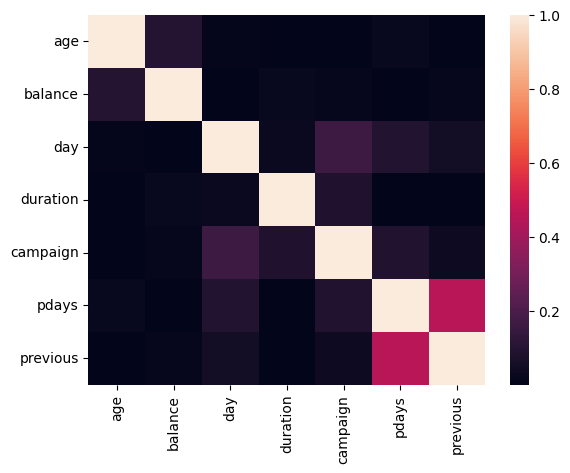

In [10]:
sns.heatmap(df[numeric_columns].corr().abs())

<p> encode y as int

In [11]:
df["y"] = (df.y == "yes").astype(int)

#### VALIDATION TEST SPLIT

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
len(df_full_train), len(df_test)

(36168, 9043)

In [14]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val)

(27126, 9042)

In [15]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [16]:
y_full_train = df_full_train.y.values
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [17]:
del df_full_train["y"]
del df_train["y"]
del df_val["y"]
del df_test["y"]

### QUESTION 3

In [18]:
from sklearn.metrics import mutual_info_score

In [19]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, y_train)

In [20]:
categorical_columns

['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome', 'y']

In [21]:
df_train[categorical_columns[:-1]].apply(mutual_info_churn_score).sort_values(ascending=False)

poutcome     0.030087
month        0.024390
contact      0.013504
housing      0.009971
job          0.007727
education    0.002781
marital      0.002003
dtype: float64

### QUESTION 4

In [22]:
from sklearn.linear_model import LogisticRegression

In [35]:
dicts_train = df_train[categorical_columns[:-1]].to_dict(orient="records")
dicts_val = df_val[categorical_columns[:-1]].to_dict(orient="records")

In [36]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer()

X_train = dv.fit_transform(dicts_train)
X_val = dv.transform(dicts_val)

In [37]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

In [38]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [39]:
y_pred = model.predict(X_val)

In [40]:
round(((y_pred == y_val).sum() / len(y_val)), 2)

np.float64(0.89)

In [41]:
full_accurracy = round(((y_pred == y_val).sum() / len(y_val)), 5)

### QUESTION 5

In [31]:
def prepare_X(cols):
    dicts_train = df_train[cols].to_dict(orient="records")
    dicts_val = df_val[cols].to_dict(orient="records")

    dv = DictVectorizer()

    X_train = dv.fit_transform(dicts_train)
    X_val = dv.transform(dicts_val)

    return X_train, X_val

In [43]:
for col_to_el in categorical_columns[:-1]:
    tmp_col = categorical_columns[:-1]
    tmp_col.remove(col_to_el)
    X_train, X_val = prepare_X(tmp_col)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    new_acc = round(((y_pred == y_val).sum() / len(y_val)), 5)
    print(f"With column {col_to_el} excluded, accuracy diff is {round(abs(new_acc - full_accurracy),5)}")


With column job excluded, accuracy diff is 0.00044
With column marital excluded, accuracy diff is 0.00033
With column education excluded, accuracy diff is 0.00055
With column housing excluded, accuracy diff is 0.00165
With column contact excluded, accuracy diff is 0.00023
With column month excluded, accuracy diff is 0.00022
With column poutcome excluded, accuracy diff is 0.00685


### QUESTION 6

In [44]:
dicts_train = df_train[categorical_columns[:-1]].to_dict(orient="records")
dicts_val = df_val[categorical_columns[:-1]].to_dict(orient="records")

In [45]:
# from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer()

X_train = dv.fit_transform(dicts_train)
X_val = dv.transform(dicts_val)

In [47]:
for c in [0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(C=c, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    new_acc = round(((y_pred == y_val).sum() / len(y_val)), 3)

    print(f"with c: {c}, yields {new_acc}")

with c: 0.01, yields 0.888
with c: 0.1, yields 0.891
with c: 1, yields 0.892
with c: 10, yields 0.892
with c: 100, yields 0.892
